In [ ]:
!python --version
!pip install tensorflow==2.9.*
!pip install opencv-python
!pip install -U matplotlib
!pip install numpy
!pip install -U scikit-learn

In [2]:
# Import Libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

from keras import Model, Input
import keras.utils as image
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from keras.callbacks import EarlyStopping
from keras import optimizers

from keras.datasets import fashion_mnist

from sklearn.model_selection import train_test_split
import os

# 5.1

Scale Factors: [0.5, 0.25, 0.125, 0.06666666666666667]


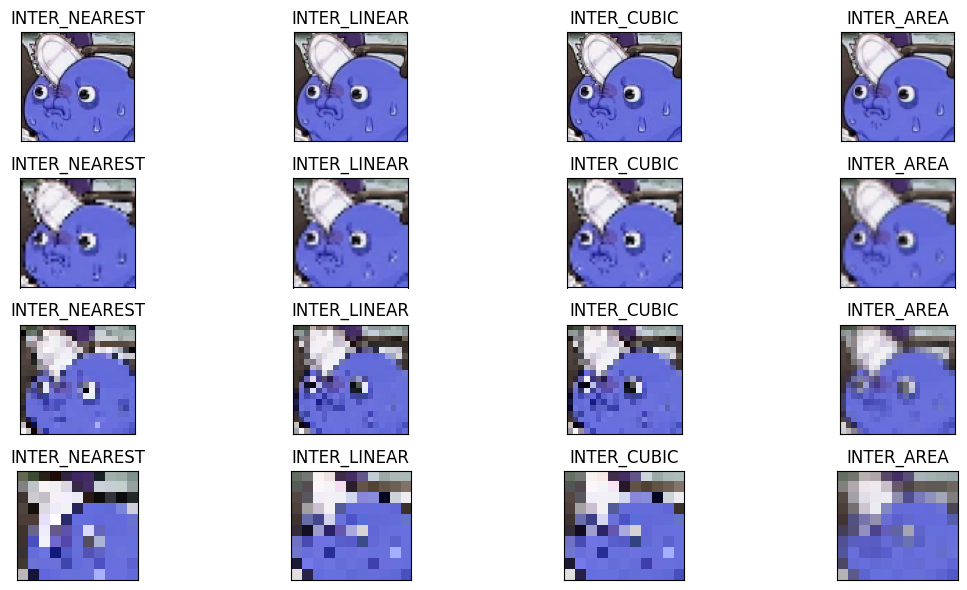

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image file
image = cv2.imread("poji.jpg")  # Update the path to your image

# Define resize factors
Reduce_factors = [2,4,8, 15]

# Calculate the scale factors
Scale_factors = [1 / factor for factor in Reduce_factors]

# Display the scale factors
print("Scale Factors:", Scale_factors)

# Define interpolation method
inter_methods = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA]
STR_methods = ["INTER_NEAREST","INTER_LINEAR", "INTER_CUBIC" ,"INTER_AREA"]
# Create a figure to display the results
plt.figure(figsize=(12, 6))

# Loop through each scale factor and interpolation method
for i, factor in enumerate(Scale_factors):
    for j, method in enumerate(inter_methods):

        # Resize the image using the current factor and method
        new_width = int(image.shape[1] * factor)
        new_height = int(image.shape[0] * factor)
        resized = cv2.resize(image, (new_width, new_height), interpolation=method)

        # Display the resized image

        plt.subplot(len(Scale_factors), len(inter_methods), i * len(inter_methods) + j + 1)
        plt.imshow(resized)
        plt.title(f"{STR_methods[j]}")
        plt.xticks([]); plt.yticks([])  # Remove x and y-axis tick marks
        plt.axis("on")

# Show the results
plt.tight_layout()
plt.show()




# 5.2

In [14]:
def add_gaussian_noise(img):
    mean = 0
    sigma = 25  # You can adjust the standard deviation as needed
    noisy_img = img + np.random.normal(mean, sigma, img.shape)
    noisy_img = np.clip(noisy_img, 0, 255)  # Clip values to stay within [0, 255] range
    noisy_img = noisy_img.astype('uint8')  # Convert back to uint8
    return noisy_img

# Define parameters
Npic = 50  # Number of augmented images to generate
rotation_range = 40
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.2
zoom_range = 0.2
horizontal_flip = True
fill_mode = ['constant', 'nearest', 'reflect', 'wrap']

#import image
img = cv2.imread('poji.jpg')
cv2.resize((cv2.cvtColor((img), cv2.COLOR_BGR2RGB)), (100, 100))


# Create a VideoWriter object to save the images as a video
output_file = 'output_video_4.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Video codec (you can change this as needed)
fps = 30.0  # Frames per second
frame_size = (img.shape[1], img.shape[0])  # Use the size of the input image
out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)


# Define ImageDataGenerator with parameters
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    preprocessing_function=add_gaussian_noise,
    fill_mode=fill_mode[3]
)

# Creates our batch of one image
img = np.expand_dims(img, axis=0)  # Add batch dimension
pic = datagen.flow(img, batch_size=1)

#Create Folder
os.makedirs('augmented_images', exist_ok=True)

# Randomly generate transformed images and write them to the video file
for i in range(1, Npic):
    batch = pic.next()
    im_result = batch[0].astype('uint8')

    # Write the transformed image to the video file
    out.write(im_result)

# Release the VideoWriter object
out.release()

### 5.3

In [7]:
import numpy as np
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize the image intensity to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add a channel dimension (rank-4 shape) for compatibility with Conv2D layers
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Split the training data into train and validation sets
x_train, x_val = train_test_split(x_train, random_state=42, test_size=0.2)


4422102/4422102 [==============================] - 0s 0us/step


In [8]:
# Define Gaussian Noise Function
def add_gaussian_noise(img, mean=0, std=1, noise_factor=0.5):
    noise = np.random.normal(mean, std, img.shape)
    noisy_img = img + noise_factor * noise
    noisy_img = np.clip(noisy_img, 0, 1)  # Ensure pixel values are in [0, 1] range
    return noisy_img

def create_autoencoder_model(optimizer, learning_rate):
    input_img = Input(shape=(28, 28, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy')

    return autoencoder

In [26]:
# Set hyperparameters
eps = 10
batch_size = 32
learning_rate = 0.001

# Create an instance of the data generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=add_gaussian_noise
)

# Create the autoencoder model
autoencoder = create_autoencoder_model(optimizer=Adam, learning_rate=learning_rate)

# Define an Early Stopping callback
callback = EarlyStopping(monitor='loss', patience=10)

# Train the autoencoder using fit_generator
history = autoencoder.fit_generator(
    datagen.flow(x_train, x_train, batch_size=batch_size),
    epochs=eps,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=datagen.flow(x_val, x_val, batch_size=batch_size),
    callbacks=[callback],
    verbose=1
)

Epoch 1/10


<ipython-input-26-342fcdd95440>:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(


1500/1500 [==============================] - 37s 24ms/step - loss: 0.3810 - val_loss: 0.3627
Epoch 2/10
1500/1500 [==============================] - 35s 24ms/step - loss: 0.3563 - val_loss: 0.3518
Epoch 3/10
1500/1500 [==============================] - 35s 23ms/step - loss: 0.3491 - val_loss: 0.3462
Epoch 4/10
1500/1500 [==============================] - 35s 23ms/step - loss: 0.3454 - val_loss: 0.3455
Epoch 5/10
1500/1500 [==============================] - 35s 23ms/step - loss: 0.3432 - val_loss: 0.3435
Epoch 6/10
1500/1500 [==============================] - 41s 27ms/step - loss: 0.3416 - val_loss: 0.3406
Epoch 7/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.3403 - val_loss: 0.3397
Epoch 8/10
1500/1500 [==============================] - 35s 24ms/step - loss: 0.3394 - val_loss: 0.3380
Epoch 9/10
1500/1500 [==============================] - 37s 24ms/step - loss: 0.3385 - val_loss: 0.3378
Epoch 10/10
1500/1500 [==============================] - 35s 23ms/step - lo

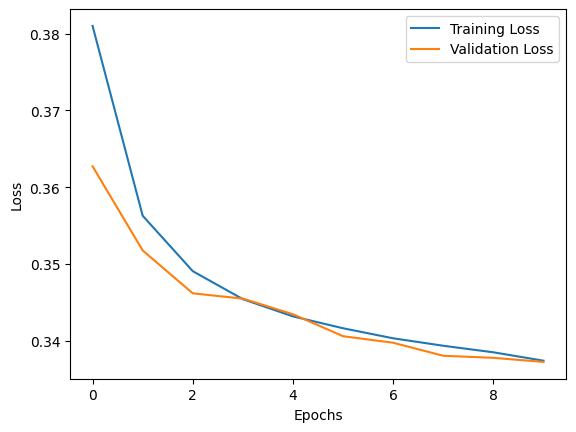

313/313 [==============================] - 1s 2ms/step


In [27]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate noisy test data
x_test_noisy = np.array([add_gaussian_noise(img) for img in x_test])

# Make predictions using the trained autoencoder
predict_test = autoencoder.predict(x_test_noisy)

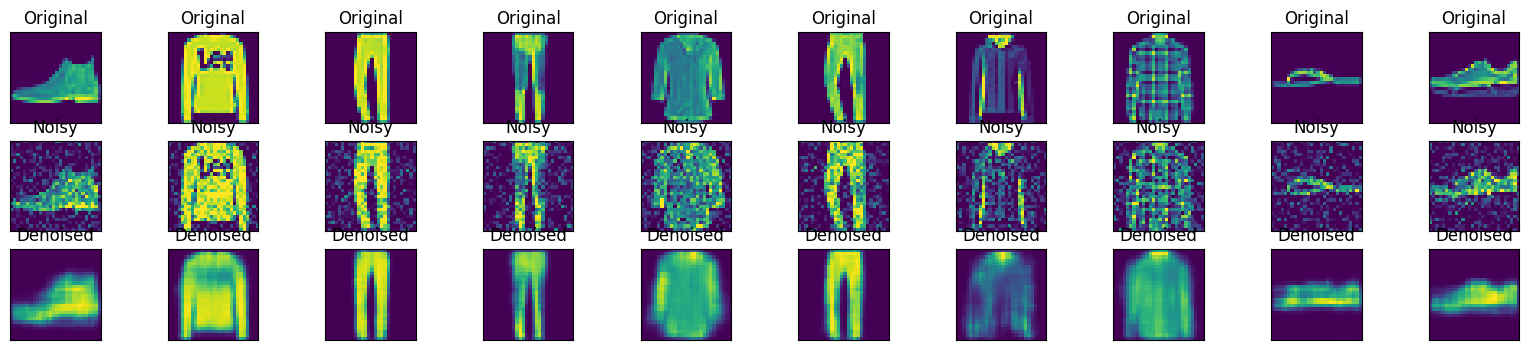

In [28]:

# Visualize original, noisy, and denoised images
n = 10  # Number of examples to visualize

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised image
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predict_test[i].reshape(28, 28))
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [23]:
# Define Gaussian Noise Function
def add_gaussian_noise(img, mean=0, std=0.6, noise_factor=0.3):
    noise = np.random.normal(mean, std, img.shape)
    noisy_img = img + noise_factor * noise
    noisy_img = np.clip(noisy_img, 0, 1)  # Ensure pixel values are in [0, 1] range
    return noisy_img
def create_model(optimizer, learning_rate):
    # Encoder
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer(learning_rate=learning_rate), loss='mean_squared_error')
    return autoencoder

eps = 10
batch_size = 16
learning_rate = 0.01


# Create the autoencoder model
autoencoder = create_model(optimizer=Adam, learning_rate=learning_rate)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    preprocessing_function=add_gaussian_noise
)

callback = EarlyStopping(monitor='loss', patience=10)
history = autoencoder.fit_generator(
    datagen.flow(x_train, x_train, batch_size=batch_size),
    epochs=eps,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=datagen.flow(x_val, x_val, batch_size=batch_size),
    callbacks=[callback],
    verbose=1
)

Epoch 1/10


<ipython-input-23-9ef0d73c872b>:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(


3000/3000 [==============================] - 42s 14ms/step - loss: 0.0560 - val_loss: 0.0552
Epoch 2/10
3000/3000 [==============================] - 42s 14ms/step - loss: 0.0544 - val_loss: 0.0545
Epoch 3/10
3000/3000 [==============================] - 41s 14ms/step - loss: 0.0541 - val_loss: 0.0537
Epoch 4/10
3000/3000 [==============================] - 42s 14ms/step - loss: 0.0538 - val_loss: 0.0539
Epoch 5/10
3000/3000 [==============================] - 40s 13ms/step - loss: 0.0538 - val_loss: 0.0539
Epoch 6/10
3000/3000 [==============================] - 43s 14ms/step - loss: 0.0538 - val_loss: 0.0534
Epoch 7/10
3000/3000 [==============================] - 40s 13ms/step - loss: 0.0538 - val_loss: 0.0530
Epoch 8/10
3000/3000 [==============================] - 42s 14ms/step - loss: 0.0537 - val_loss: 0.0533
Epoch 9/10
3000/3000 [==============================] - 41s 14ms/step - loss: 0.0538 - val_loss: 0.0537
Epoch 10/10
3000/3000 [==============================] - 42s 14ms/step - lo

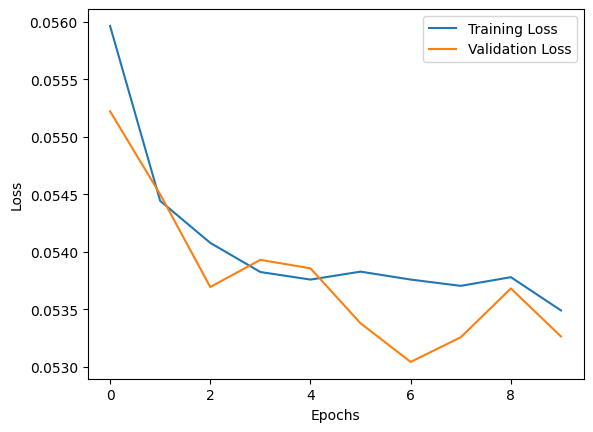

313/313 [==============================] - 1s 2ms/step


In [24]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate noisy test data
x_test_noisy = np.array([add_gaussian_noise(img) for img in x_test])

# Make predictions using the trained autoencoder
predict_test = autoencoder.predict(x_test_noisy)

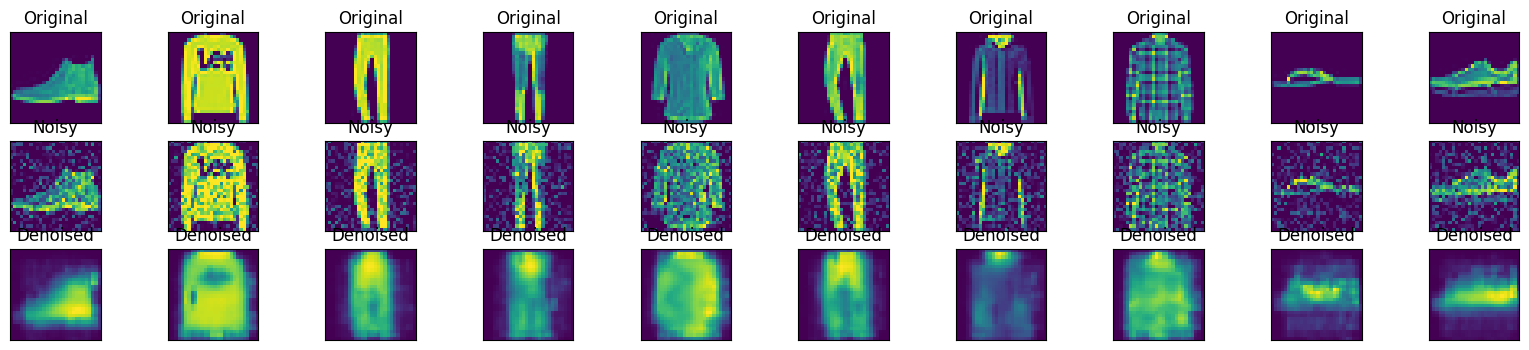

In [25]:

# Visualize original, noisy, and denoised images
n = 10  # Number of examples to visualize

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised image
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predict_test[i].reshape(28, 28))
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()